In [120]:
%matplotlib notebook

from DataSets import *
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.BoundingBox import BoundingBox
#from RegressionRun import *
import matplotlib as mpl
import pandas as pd
import numpy.ma as ma
#from MalardClient import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [166]:
# read file regression
dfStats = gp.read_file("regression_results/himalayas-gridcells.gpkg")
dfStatsHalf = gp.read_file("regression_results/himalayas-gridcells-half.gpkg")
dfStatsDouble = gp.read_file("regression_results/himalayas-gridcells-double.gpkg")

dfTimeseries = pd.read_json("timeseries_results/himalayas-gridcells.json")
dfTimeseriesHalf = pd.read_json("timeseries_results/himalayas-gridcells-half.json")
dfTimeseriesDouble = pd.read_json("timeseries_results/himalayas-gridcells-double.json")

In [167]:
# remove all Stats that are nan
dfStats=dfStats[dfStats['regression.count'].notnull()]
dfStatsHalf=dfStatsHalf[dfStatsHalf['regression.count'].notnull()]
dfStatsDouble=dfStatsDouble[dfStatsDouble['regression.count'].notnull()]

dfTimeseries=dfTimeseries[dfTimeseries['timeseries.dates'].notnull()]
dfTimeseriesHalf=dfTimeseriesHalf[dfTimeseriesHalf['timeseries.dates'].notnull()]
dfTimeseriesDouble=dfTimeseriesDouble[dfTimeseriesDouble['timeseries.dates'].notnull()]


In [168]:
# get number of 3 month time intervals that contain data
def unique_3m(timeseries):
    if timeseries is not None and timeseries is not np.nan:
        return len(set(timeseries))-1
    else:
        return None

dfTimeseries['unique_3m']=dfTimeseries.apply(lambda x: unique_3m(x['timeseries.{}'.format('averages')]), axis=1)
dfTimeseriesHalf['unique_3m']=dfTimeseriesHalf.apply(lambda x: unique_3m(x['timeseries.{}'.format('averages')]), axis=1)
dfTimeseriesDouble['unique_3m']=dfTimeseriesDouble.apply(lambda x: unique_3m(x['timeseries.{}'.format('averages')]), axis=1)

In [169]:
#Merge
dfStats = dfStats.merge(dfTimeseries, how='left', on=['minX','minY'])
dfStatsHalf = dfStatsHalf.merge(dfTimeseriesHalf, how='left', on=['minX','minY'])
dfStatsDouble = dfStatsDouble.merge(dfTimeseriesDouble, how='left', on=['minX','minY'])


In [170]:
# stdev of timeseries
def std_3m(timeseries, dates, rate, const):
    if timeseries is not None:
        ratesremoved=[]
        for i,date in enumerate(dates):
            if timeseries[i] is not None:
                reg_value = const+(rate*(date/1000))
                ratesremoved.append(timeseries[i]-reg_value)
        #res = [i for i in timeseries if i]
        return np.std(np.array(ratesremoved))
    else:
        return None

dfStatsDouble['std_3m']=dfStatsDouble.apply(lambda x: std_3m(x['timeseries.{}'.format('averages')], x['timeseries.{}'.format('dates')], x['regression.{}.c'.format('w_powercoh')], x['regression.{}.const'.format('w_powercoh')]), axis=1)
dfStatsHalf['std_3m']=dfStatsHalf.apply(lambda x: std_3m(x['timeseries.{}'.format('averages')], x['timeseries.{}'.format('dates')], x['regression.{}.c'.format('w_powercoh')], x['regression.{}.const'.format('w_powercoh')]), axis=1)
dfStats['std_3m']=dfStats.apply(lambda x: std_3m(x['timeseries.{}'.format('averages')], x['timeseries.{}'.format('dates')], x['regression.{}.c'.format('w_powercoh')], x['regression.{}.const'.format('w_powercoh')]), axis=1)


In [171]:
# plot preparation:
rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)
vmin=-2
vmax=2



In [172]:
def plotMap():

    fig, ax = plt.subplots(1,3,sharey=True,sharex=True,figsize=(10,5.25))

    countries.plot(ax=ax[0], edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax[0], edgecolor='blue', linewidth=0.25)
    countries.plot(ax=ax[1], edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax[1], edgecolor='blue', linewidth=0.25)
    countries.plot(ax=ax[2], edgecolor='grey', color='lightgrey', linewidth=0.5)
        
    dfStatsHalf.plot(ax=ax[0],column='regression.w_powercoh.c.year', vmin=vmin, \
                         vmax=vmax, cmap=cm)
    dfStats.plot(ax=ax[1],column='regression.w_powercoh.c.year', vmin=vmin, \
                         vmax=vmax, cmap=cm)
    dfStatsDouble.plot(ax=ax[2],column='regression.w_powercoh.c.year', vmin=vmin, \
                         vmax=vmax, cmap=cm)

    #bar=fig.colorbar(ax=ax[2], orientation='horizontal', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    #bar.set_label('Elevation change [m/yr]')

    #plt.title('DhDt Himalayas')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[2].set_yticklabels([])
    ax[2].set_xticklabels([])
    ax[0].set_title("50'000km gridcells")
    ax[1].set_title("100'000km gridcells")
    ax[2].set_title("200'000km gridcells")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<IPython.core.display.Javascript object>


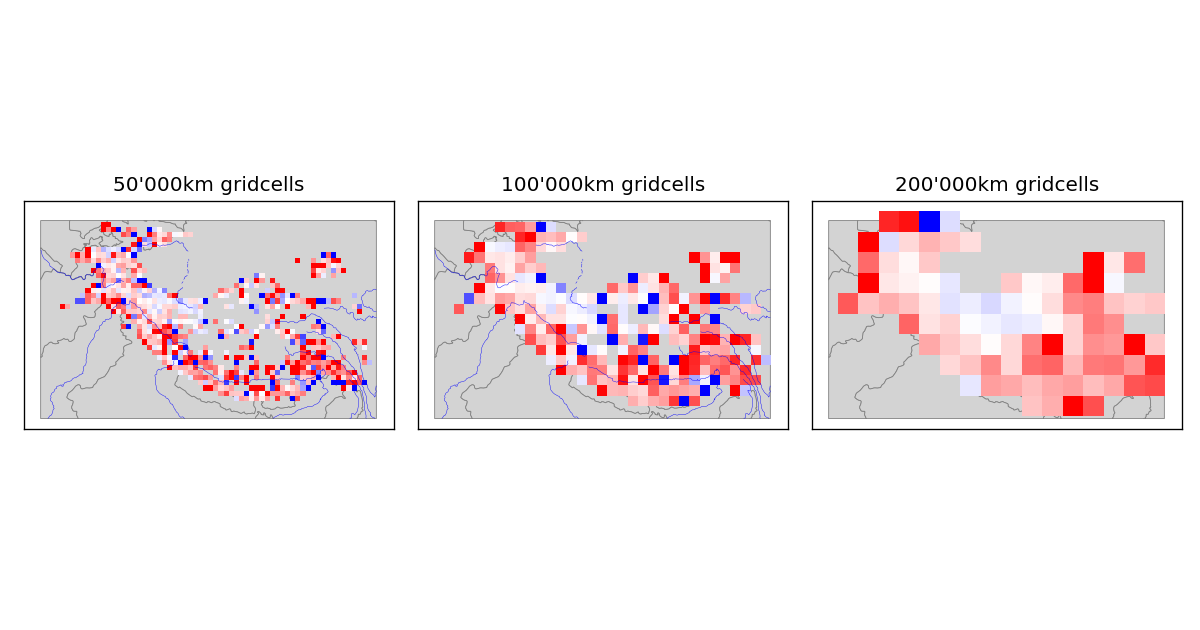

In [173]:
plotMap()

In [175]:
dfStatsLowError=dfStats[(dfStats['regression.noel.w_powercoh.error']<1) & (dfStats['unique_3m']>28) & (dfStats['std_3m']<25)]
dfStatsHalfLowError=dfStatsHalf[(dfStatsHalf['regression.noel.w_powercoh.error']<1) & (dfStatsHalf['unique_3m']>28) & (dfStatsHalf['std_3m']<25)]
dfStatsDoubleLowError=dfStatsDouble[(dfStatsDouble['regression.noel.w_powercoh.error']<1) & (dfStatsDouble['unique_3m']>28) & (dfStatsDouble['std_3m']<25)]

In [176]:
def plotMapErrorsAll():

    fig, ax = plt.subplots(1,3,sharey=True,sharex=True,figsize=(10,5.25))

    countries.plot(ax=ax[0], edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax[0], edgecolor='blue', linewidth=0.25)
    countries.plot(ax=ax[1], edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax[1], edgecolor='blue', linewidth=0.25)
    countries.plot(ax=ax[2], edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax[2], edgecolor='blue', linewidth=0.25)

    dfStatsHalfLowError.plot(ax=ax[0],column='regression.w_powercoh.c.year', vmin=vmin, \
                         vmax=vmax, cmap=cm)
    dfStatsLowError.plot(ax=ax[1],column='regression.w_powercoh.c.year', vmin=vmin, \
                         vmax=vmax, cmap=cm)
    dfStatsDoubleLowError.plot(ax=ax[2],column='regression.w_powercoh.c.year', vmin=vmin, \
                         vmax=vmax, cmap=cm)

    #bar=fig.colorbar(ax=ax[2], orientation='horizontal', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    #bar.set_label('Elevation change [m/yr]')

    #plt.title('DhDt Himalayas')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[2].set_yticklabels([])
    ax[2].set_xticklabels([])
    ax[0].set_title("50'000km gridcells")
    ax[1].set_title("100'000km gridcells")
    ax[2].set_title("200'000km gridcells")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<IPython.core.display.Javascript object>


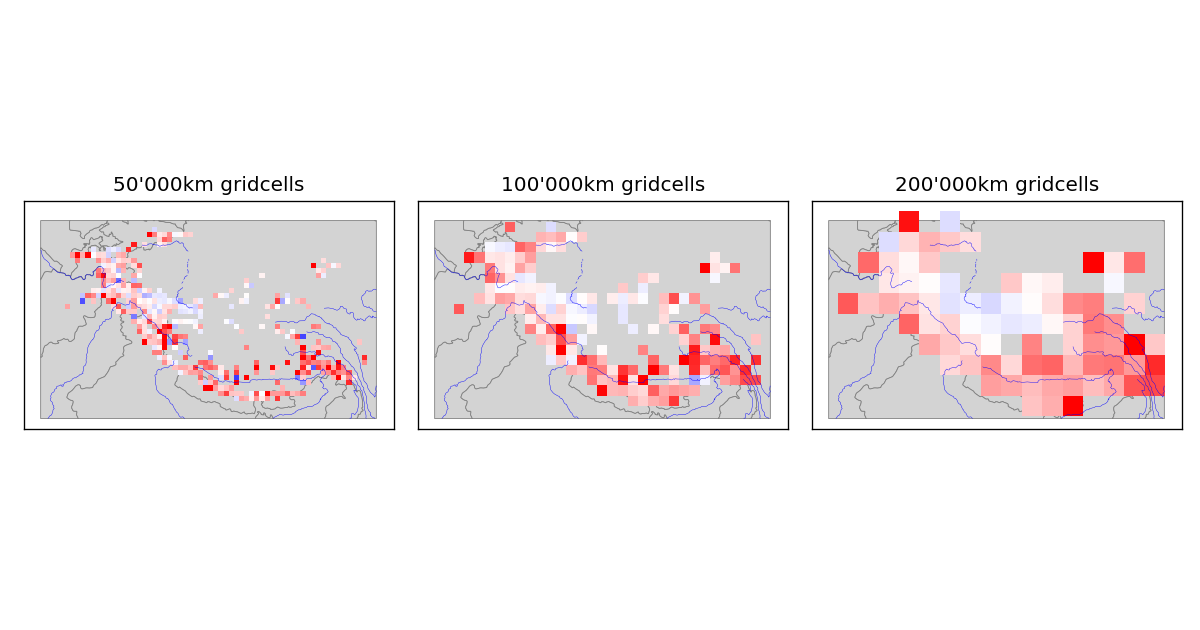

In [177]:
plotMapErrorsAll()

In [25]:
def plotMapErrors(row, lowError, regression, title=''):

    fig, ax = plt.subplots(figsize=(11,5.25))

    countries.plot(ax=ax, edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax, edgecolor='blue', linewidth=0.25)

    if lowError:
        dfStatsLowError.plot(column='regression.{}.c.year'.format(regression), vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax)
    else:
        dfStats.plot(column='regression.{}.c.year'.format(regression), vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax)

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change [m/yr]')

    #plt.title('DhDt Himalayas')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


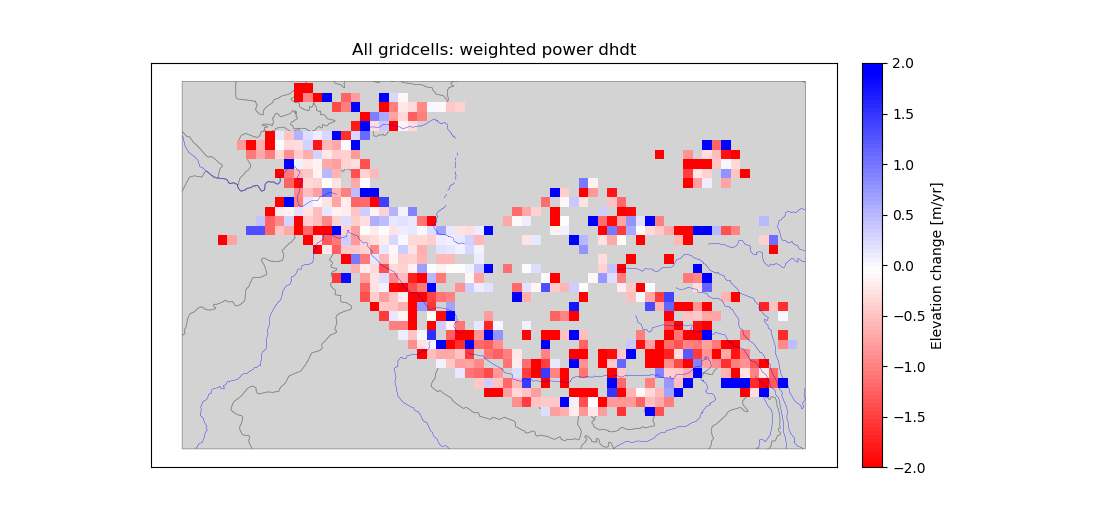

In [27]:
plotMapErrors(0, lowError=False, regression='w_powercoh', title='All gridcells: weighted power dhdt')

<IPython.core.display.Javascript object>


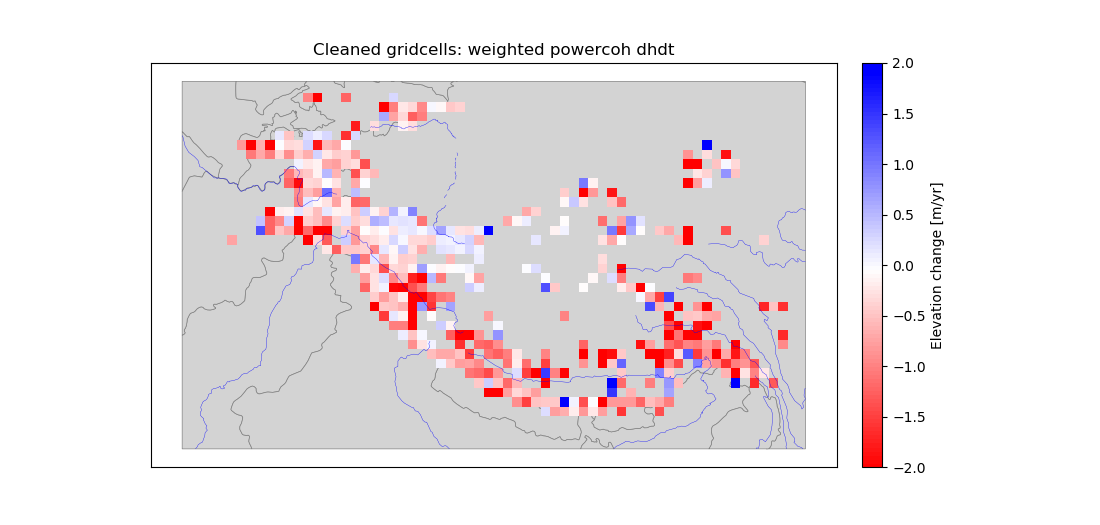

In [28]:
plotMapErrors(0, lowError=True, regression='w_powercoh', title='Cleaned gridcells: weighted powercoh dhdt')

In [31]:
def plotErrors(title=''):
    # change this to change min and max of colors
    mincol=0
    maxcol=1
    
    fig, ax = plt.subplots(figsize=(11,5.25))

    countries.plot(ax=ax, edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax, edgecolor='blue', linewidth=0.25)

    dfStats.plot(column='regression.noel.w_power.error', vmin=mincol, \
                         vmax=maxcol, ax=ax)

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mincol, vmax=maxcol), cmap='viridis'))
    bar.set_label('Error [m/yr]')

    #plt.title('DhDt Himalayas')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


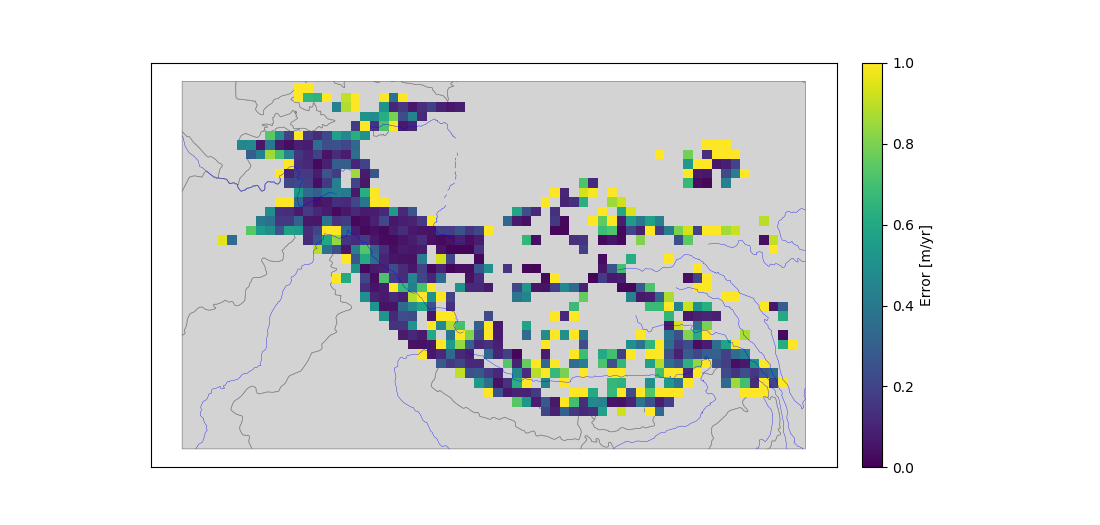

In [32]:
plotErrors()

In [39]:
def plotThresholds(title=''):
    # change this to change min and max of colors
    mincol=100
    maxcol=1001
    
    fig, ax = plt.subplots(figsize=(11,5.25))

    countries.plot(ax=ax, edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax, edgecolor='blue', linewidth=0.25)

    dfStatsLowError.plot(column='regression.w_power.count', vmin=mincol, \
                         vmax=maxcol, ax=ax)


    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mincol, vmax=maxcol), cmap='viridis'))
    bar.set_label('Error [m/yr]')

    #plt.title('DhDt Himalayas')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


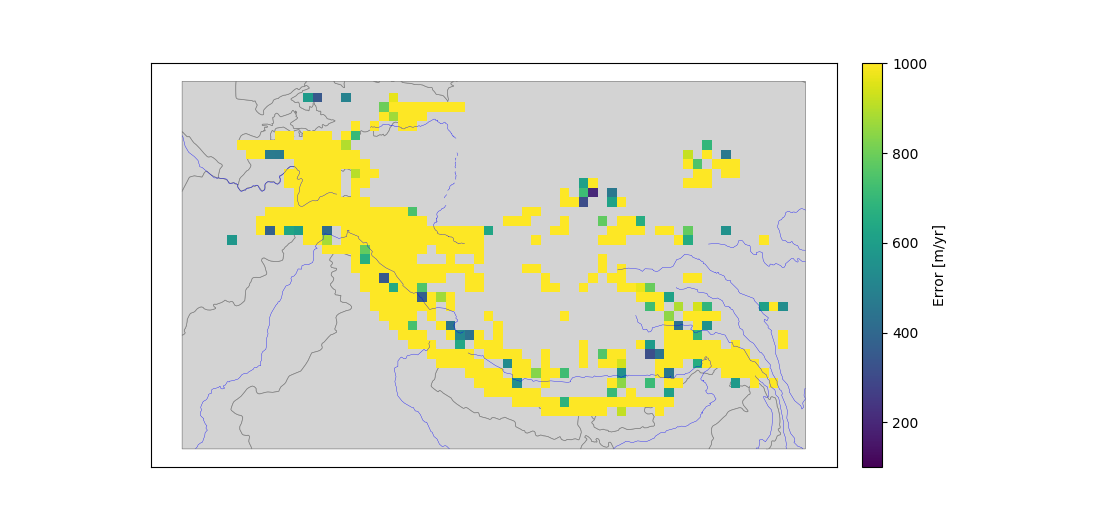

In [40]:
plotThresholds()

In [42]:
dfStats['mass_change']=(dfStats['regression.w_powercoh.c.year']/1000000)*dfStats['statistics.GlacierMaskArea']*850

In [267]:
dfStats['mass_change'].sum()

-24.291230554205914

In [266]:
dfStatsLowError=dfStats[(dfStats['regression.noel.w_powercoh.error']<1) & (dfStats['regression.w_powercoh.time_unique']>30)]
dfStatsLowError['mass_change'].sum()

-29.510808383494386

In [269]:
dfStatsLowError.to_file('/home/livia/QGIS-Projects/mntglatest.gpkg', driver="GPKG")